In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
x = np.linspace(0,50,501)

In [ ]:
# x

In [3]:
y = np.sin(x)

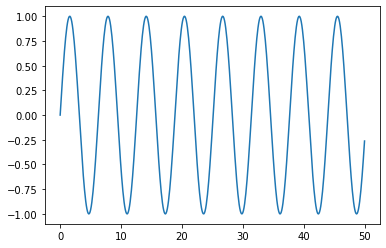

In [4]:
plt.plot(x,y)

In [5]:
df = pd.DataFrame(data=y,index=x,columns=['Sine'])

In [6]:
df

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
49.6,-0.617439
49.7,-0.535823
49.8,-0.448854
49.9,-0.357400


In [7]:
train_set = df.iloc[:451]
test_set = df.iloc[451:]

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler = MinMaxScaler()

In [10]:
scaled_train = scaler.fit_transform(train_set)
scaled_test = scaler.transform(test_set)

In [11]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [12]:
help(TimeseriesGenerator)

Help on class TimeseriesGenerator in module tensorflow.python.keras.preprocessing.sequence:

class TimeseriesGenerator(keras_preprocessing.sequence.TimeseriesGenerator, tensorflow.python.keras.utils.data_utils.Sequence)
 |  TimeseriesGenerator(data, targets, length, sampling_rate=1, stride=1, start_index=0, end_index=None, shuffle=False, reverse=False, batch_size=128)
 |  
 |  Utility class for generating batches of temporal data.
 |  
 |  This class takes in a sequence of data-points gathered at
 |  equal intervals, along with time series parameters such as
 |  stride, length of history, etc., to produce batches for
 |  training/validation.
 |  # Arguments
 |      data: Indexable generator (such as list or Numpy array)
 |          containing consecutive data points (timesteps).
 |          The data should be at 2D, and axis 0 is expected
 |          to be the time dimension.
 |      targets: Targets corresponding to timesteps in `data`.
 |          It should have same length as `data`

In [16]:
length = 25
batch_size = 1

generator = TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=batch_size)

In [14]:
len(scaled_train)

451

In [17]:
len(generator)

426

In [18]:
X,y = generator[0]

In [19]:
X

array([[[0.49999912],
        [0.54991622],
        [0.59933458],
        [0.64776041],
        [0.69470985],
        [0.73971381],
        [0.78232262],
        [0.82211054],
        [0.85868004],
        [0.89166571],
        [0.92073798],
        [0.94560637],
        [0.9660224 ],
        [0.98178208],
        [0.99272794],
        [0.99875061],
        [0.99978993],
        [0.9958355 ],
        [0.98692684],
        [0.97315296],
        [0.95465148],
        [0.93160726],
        [0.90425056],
        [0.87285471],
        [0.83773342]]])

In [20]:
y

array([[0.79923759]])

<AxesSubplot:>

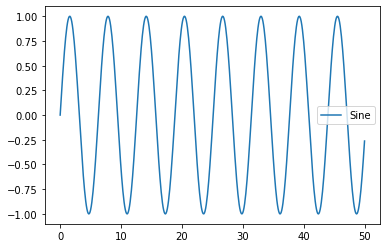

In [21]:
df.plot()

In [22]:
length = 50
batch_size = 1

generator = TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=batch_size)

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM

In [24]:
n_features = 1

In [50]:
model = Sequential()

model.add(SimpleRNN(50,input_shape=(length,n_features)))

model.add(Dense(1))

model.compile(loss='mse',optimizer='adam')

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 50)                2600      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.fit_generator(generator,epochs=5)

Epoch 1/5
401/401 [==============================] - 1s 4ms/step - loss: 0.0092
Epoch 2/5
401/401 [==============================] - 1s 4ms/step - loss: 8.3120e-04
Epoch 3/5
401/401 [==============================] - 1s 4ms/step - loss: 6.1606e-05
Epoch 4/5
401/401 [==============================] - 1s 4ms/step - loss: 4.5777e-05
Epoch 5/5
401/401 [==============================] - 1s 4ms/step - loss: 5.1906e-05


In [52]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

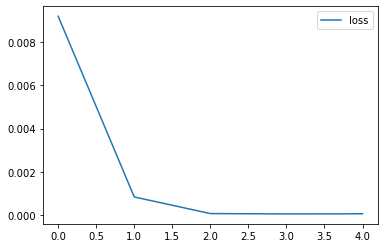

In [53]:
losses.plot()

In [44]:
scaled_train.shape

(451, 1)

In [54]:
first_eval_batch= scaled_train[-length:]

In [55]:
first_eval_batch=first_eval_batch.reshape((1,length,n_features))

In [33]:
b=model.predict(first_eval_batch)[0]
c=model.predict(first_eval_batch)

In [34]:
b

array([0.9477286], dtype=float32)

In [35]:
c

array([[0.9477286]], dtype=float32)

In [56]:
test_pred = []
#it was already implemented above but i just wanted to redo it again so that i can understand it better.
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(len(scaled_test)):
    #predicts the 51th item based on the 50 in the current_batch.
    current_pred = model.predict(current_batch)[0]
    #the prediction is then appened into the test_pred for saving
    test_pred.append(current_pred)
    #then the current batch is updated to add the new prediction as its 50th item and drop the first item to stay at 50 items.
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [57]:
#we need to inverse the scaling as we did not in the model.
true_pred = scaler.inverse_transform(test_pred)

In [58]:
test_set['predictions']=true_pred

<ipython-input-58-d685c02309b9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predictions']=true_pred


<AxesSubplot:>

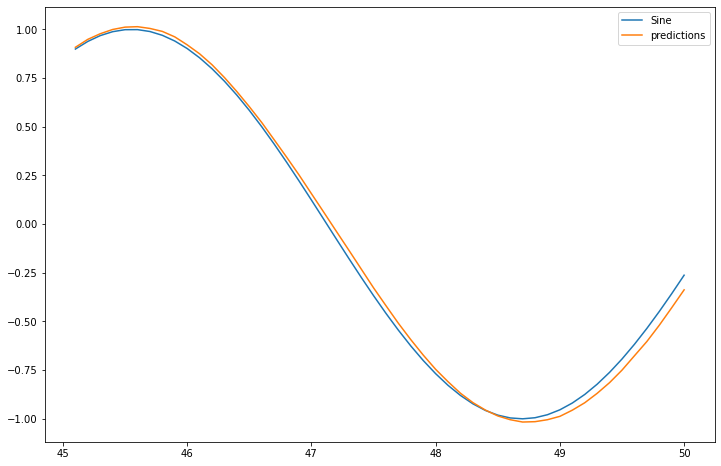

In [59]:
test_set.plot(figsize=(12,8))

In [60]:
from tensorflow.keras.callbacks import EarlyStopping

In [61]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [62]:
length = 49

generator = TimeseriesGenerator(scaled_train,scaled_train,
                               length=length,batch_size=1)

validation_generator = TimeseriesGenerator(scaled_test,scaled_test,
                                           length=length,batch_size=1)

In [63]:
model = Sequential()

model.add(LSTM(50,input_shape=(length,n_features)))

model.add(Dense(1))

model.compile(loss='mse',optimizer='adam')

In [64]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [65]:
model.fit_generator(generator,epochs=20,validation_data=validation_generator,callbacks=[early_stop])

Epoch 1/20
402/402 [==============================] - 4s 9ms/step - loss: 0.0144 - val_loss: 1.0550e-04
Epoch 2/20
402/402 [==============================] - 3s 8ms/step - loss: 1.6518e-04 - val_loss: 5.8245e-05
Epoch 3/20
402/402 [==============================] - 3s 8ms/step - loss: 3.7119e-04 - val_loss: 1.7117e-05
Epoch 4/20
402/402 [==============================] - 3s 8ms/step - loss: 2.7328e-04 - val_loss: 3.0352e-05
Epoch 5/20
402/402 [==============================] - 3s 8ms/step - loss: 4.7493e-05 - val_loss: 1.3135e-05
Epoch 6/20
402/402 [==============================] - 3s 8ms/step - loss: 8.0697e-05 - val_loss: 2.0850e-06
Epoch 7/20
402/402 [==============================] - 3s 8ms/step - loss: 3.4641e-04 - val_loss: 3.5000e-06
Epoch 8/20
402/402 [==============================] - 3s 8ms/step - loss: 2.6840e-04 - val_loss: 1.6573e-06
Epoch 9/20
402/402 [==============================] - 3s 8ms/step - loss: 2.2166e-05 - val_loss: 1.4090e-08
Epoch 10/20
402/402 [===========

In [66]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

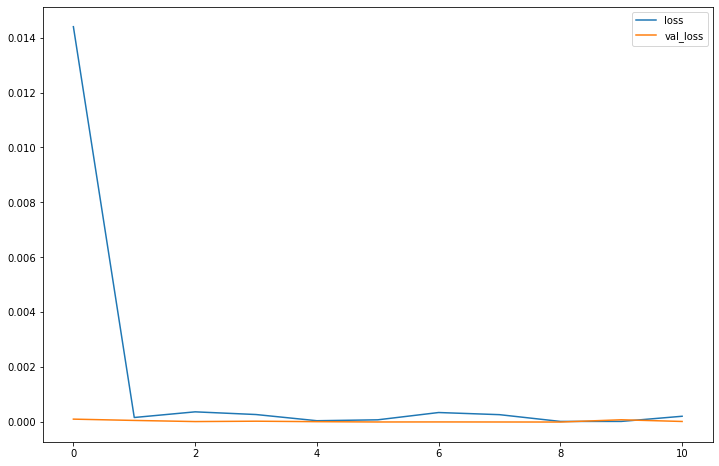

In [68]:
losses.plot(figsize=(12,8))

In [69]:
test_pred = []
#it was already implemented above but i just wanted to redo it again so that i can understand it better.
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(len(scaled_test)):
    #predicts the 51th item based on the 50 in the current_batch.
    current_pred = model.predict(current_batch)[0]
    #the prediction is then appened into the test_pred for saving
    test_pred.append(current_pred)
    #then the current batch is updated to add the new prediction as its 50th item and drop the first item to stay at 50 items.
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

<ipython-input-70-61c4325dd986>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predictions']=true_pred


<AxesSubplot:>

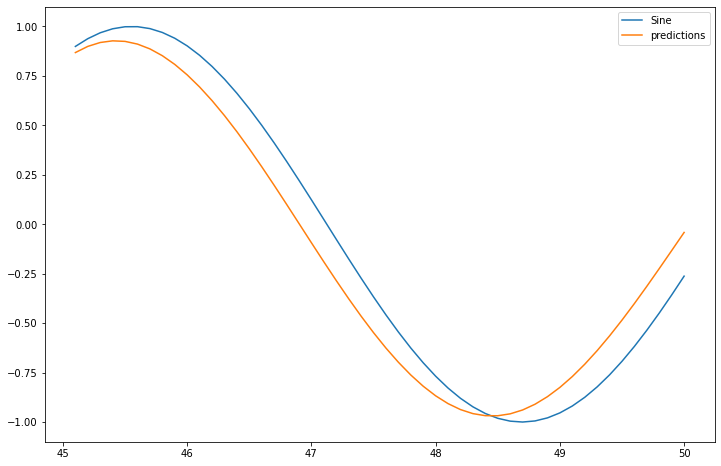

In [70]:
true_pred = scaler.inverse_transform(test_pred)
#this is for the relation between the LSTM model and the real series.
test_set['predictions']=true_pred
test_set.plot(figsize=(12,8))

In [73]:
full_scaler= MinMaxScaler()
scaled_full_data=full_scaler.fit_transform(df)

In [74]:
generator = TimeseriesGenerator(scaled_full_data,scaled_full_data,
                               length=length,batch_size=1)

In [75]:
model = Sequential()

model.add(LSTM(50,input_shape=(length,n_features)))

model.add(Dense(1))

model.compile(loss='mse',optimizer='adam')

In [76]:
model.fit_generator(generator,epochs=6)

Epoch 1/6
452/452 [==============================] - 4s 8ms/step - loss: 0.0102
Epoch 2/6
452/452 [==============================] - 4s 8ms/step - loss: 1.1137e-04
Epoch 3/6
452/452 [==============================] - 4s 8ms/step - loss: 2.3124e-04
Epoch 4/6
452/452 [==============================] - 4s 8ms/step - loss: 3.8718e-04
Epoch 5/6
452/452 [==============================] - 4s 8ms/step - loss: 3.2296e-05
Epoch 6/6
452/452 [==============================] - 4s 8ms/step - loss: 7.9699e-05


In [77]:
losses= pd.DataFrame(model.history.history)

<AxesSubplot:>

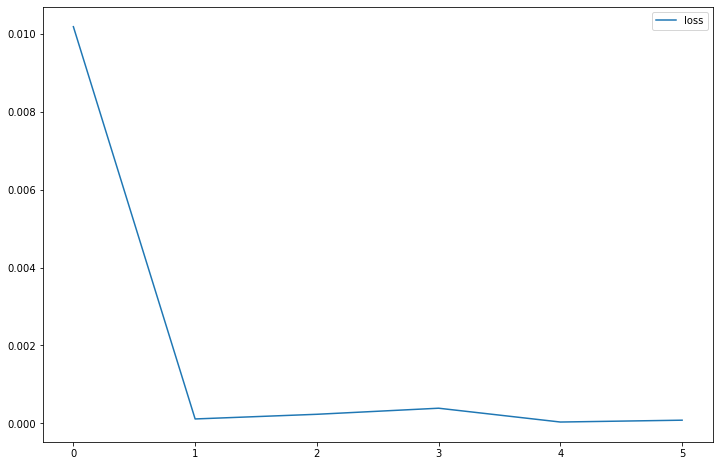

In [78]:
losses.plot(figsize=(12,8))

In [80]:
forecast = []
#it was already implemented above but i just wanted to redo it again so that i can understand it better.
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(25):
    #predicts the 51th item based on the 50 in the current_batch.
    current_pred = model.predict(current_batch)[0]
    #the prediction is then appened into the test_pred for saving
    forecast.append(current_pred)
    #then the current batch is updated to add the new prediction as its 50th item and drop the first item to stay at 50 items.
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [81]:
forecast = scaler.inverse_transform(forecast)

In [83]:
forecast_index = np.arange(50.1,52.6,step=0.1)

In [85]:
len(forecast_index)

25

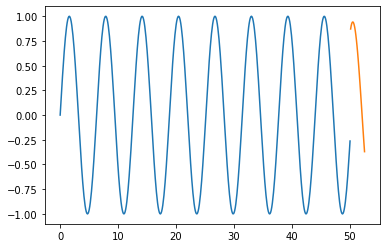

In [87]:
plt.plot(df.index,df['Sine'])
plt.plot(forecast_index,forecast)